  #        Notebook de déployement sur Sagemaker de AWS 
  
  
  
  ###           Par   Hamadi Zarrouk   -    Parcours Data-Sciences  -    23/mars/2022

# <u>PROJET 8: "Déployez un modèle dans le cloud"
    **Configuration:**
- Ce notebook est exécuté sur une instance AWS Sagemaker, de type t2.médium.  
- Le script contenu dans ce notebook ne peuvent fonctionner qu'après avoir téléchargé et installé Anaconda 3 (version 2019/03), Java 8, Scala 12, ainsi que Spark version 2.4.7 avec hadoop 2.7.
- Il est nécessaire d'intaller les packages suivants: findspark, boto3, opencv-python, numpy
- Cette instance est capable d'accéder au compartiments S3 de mon compte AWS, grâce au rôle IAM qui lui a été attribué. Il n'est donc pas nécessaire de configurer les credentials AWS au début du script. 
- L'accès à ce notebook jupyter se fait via serveur web, comme indiqué dans ce tutoriel: https://openclassrooms.com/fr/courses/4452741-decouvrez-les-librairies-python-pour-la-data-science/5559821-lancez-une-session-de-notebook-jupyter-sur-aws

  **Contexte**
- Ce notebook permet d'évaluer la faisabilité d'établissement d'une chaîne de prétraitement de données visuelles.
- Le données (images de fruits contenues dans un dossier par catégorie) sont stockées sur le cloud en utilisant le service s3.
- Nous utiliserons Spark afin de parralléliser les opérations de calcul sur tous les processeurs disponibles.
- L'objectif de ce script est d'importer les images, extraires leurs catégories, extraire les points d'intérêt de chaque image (avec descripteurs ORB), et réduire la dimension des descripteurs des points d'intérêt de chaque image avec une ACP. Les résultats de ces transformations seront enfin transférées et stockées dans un dossier 'results' dans le bucket S3 contenant les données initiales.

## <u>Sommaire:
### [I. Chargement des images dans un dataframe Spark](#section)
### [II. Détection et extraction de features avec descripteurs ](#section2)
### [III. Réduction dimensionnelle des descripteurs (ACP)](#section3)
### [VI. Enregistrement des résultats sur le répertoire S3](#section4)

In [1]:
# installation de pyspark
! pip install --upgrade pyspark

In [2]:
! pip install sparkdl

In [3]:
! pip install keras

In [4]:
! pip install tensorflow

In [5]:
! pip install tensorframes

In [6]:
! pip install findspark

In [7]:
# Renseignement du nom de mon Bucket sur AWS
S3 = True
bucket_name = 'projet8-zh'

In [8]:
import glob
import time
import io
import os
#import numpy as np
from PIL import Image
    
#import Spark
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema

In [9]:
# Costruction d'une session spark
spark = SparkSession.builder.appName('Projet8').getOrCreate()
sc = spark.sparkContext

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [10]:
# Import des fichiers jars
! cd $SPARK_HOME/jars/
! cp hadoop-aws-3.3.1.jar $SPARK_HOME/jars/
! cp aws-java-sdk-bundle-1.11.901.jar $SPARK_HOME/jars/

In [11]:
spark

In [12]:
sc

<SparkContext master=local[*] appName=Projet8>

In [13]:
# Rensignements du dossier Sample dans mon bucket
path_img = "s3a://"+bucket_name+"/Sample/*.jpg"

In [14]:
path_img

's3a://projet8-zh/Sample/*.jpg'

In [15]:
df_img = spark.read.format("image").load(path_img).repartition(10)

In [16]:
df_img.show()

+--------------------+
|               image|
+--------------------+
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
|{s3a://projet8-zh...|
+--------------------+
only showing top 20 rows



In [17]:
df_img.count()

1492

In [18]:
df_img.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [19]:
df_img.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(10), REPARTITION_BY_NUM, [id=#87]
   +- FileScan image [image#0] Batched: false, DataFilters: [], Format: org.apache.spark.ml.source.image.ImageFileFormat@4e29b9ec, Location: InMemoryFileIndex(1492 paths)[s3a://projet8-zh/Sample/0_100.jpg, s3a://projet8-zh/Sample/100_100...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<image:struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>>




(100, 100, 3)


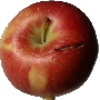

In [20]:
# Affichage d'une image
import numpy as np
a = df_img.first()
b = np.array(a.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1]
print(b.shape)
Image.fromarray(b, 'RGB')

In [21]:
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans

In [22]:
scaler = StandardScaler()

In [23]:
loops = df_img.select("image").collect()

In [24]:
fruit_images = []
for i in loops:
    try:
        fruit_images.append(np.array(i.asDict()['image']['data']).reshape(100,100,3)[:,:,::-1])
    except : 
        pass 

In [25]:
images_scaled = scaler.fit_transform([i.flatten() for i in fruit_images])

In [26]:
len(images_scaled)

1492

In [27]:
## <u>III. Réduction dimensionnelle des descripteurs (ACP)<u><a name="section3"></a><u>


Il est alors possible de réaliser une analyse en composante principale sur 20 composantes (par exemple) afin de réduire la taille des descripteurs.

In [29]:
pca = PCA(n_components=20)
pca_model = pca.fit(images_scaled)
pca_result = pca.transform(images_scaled)

In [30]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [33]:
def visualize_scatter_with_images(data_2d, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    artists = []
    for xy, i in zip(data_2d, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(data_2d)
    ax.autoscale()
    plt.show()

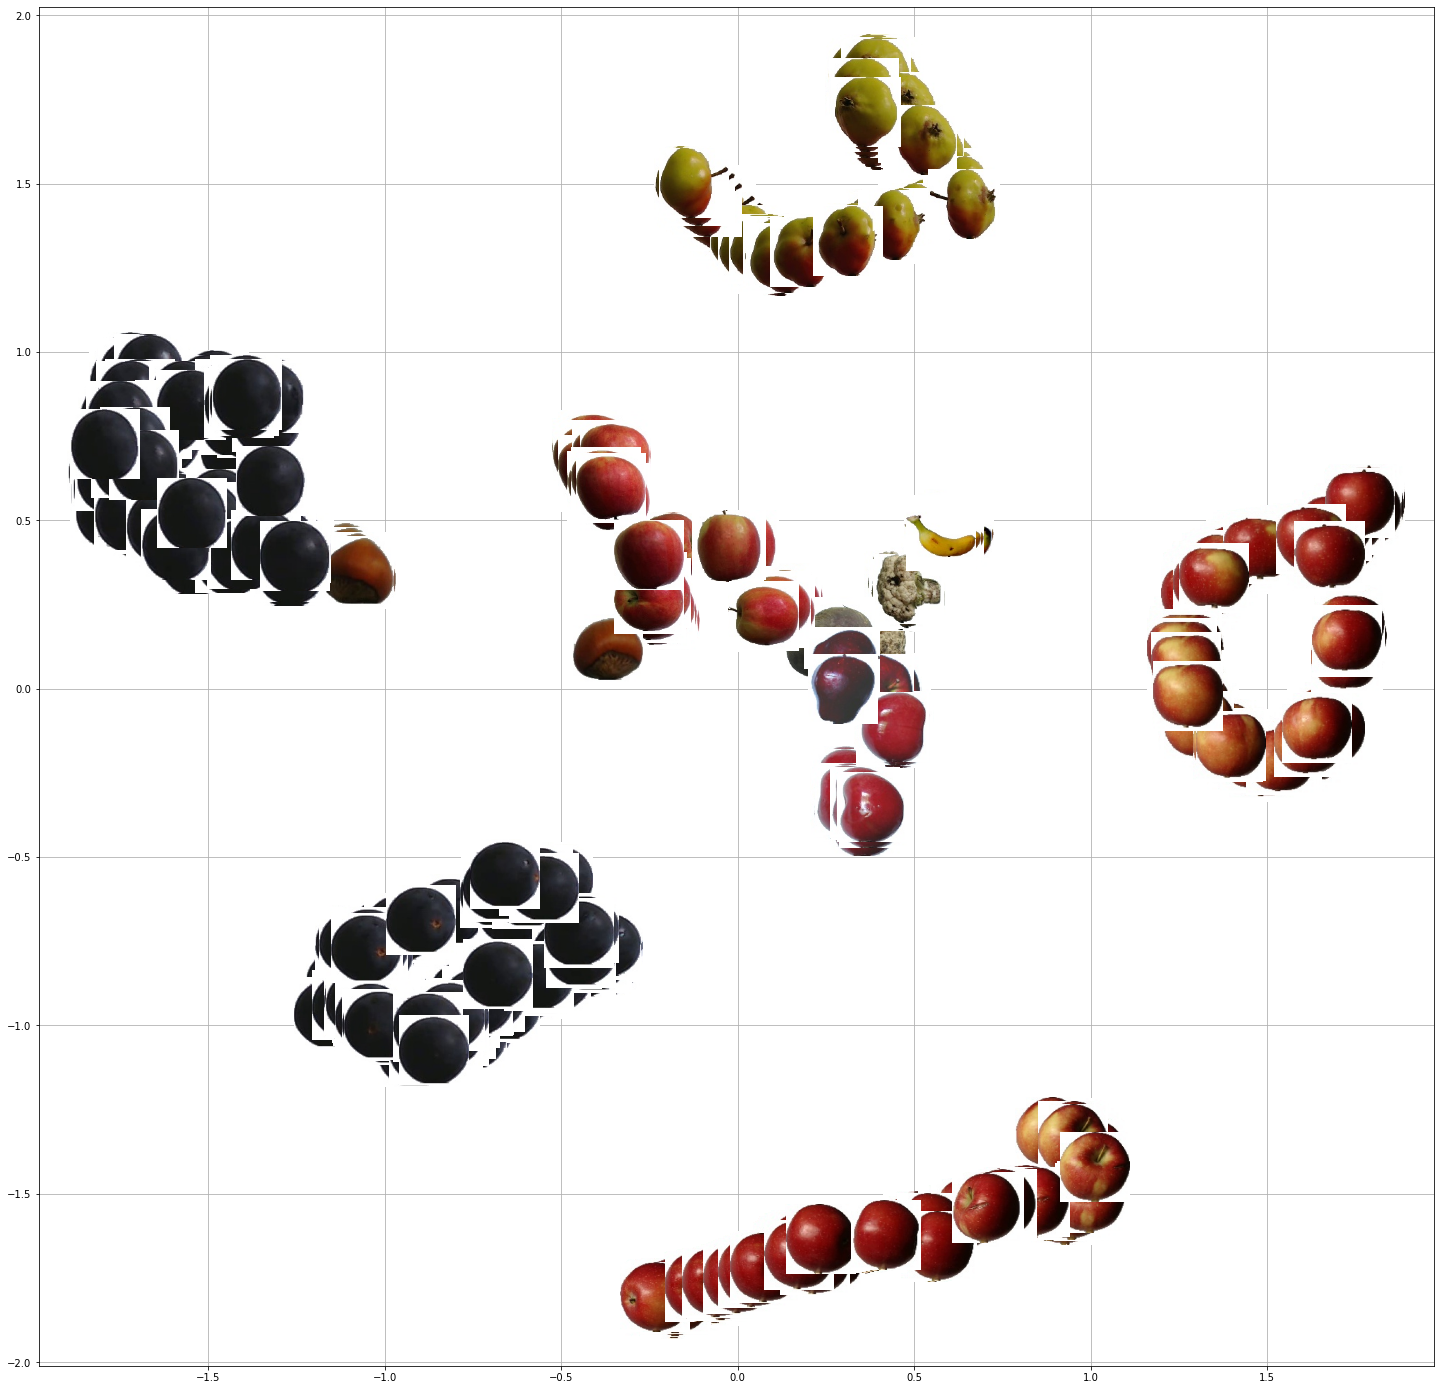

In [58]:
visualize_scatter_with_images(tsne_result_scaled, fruit_images, image_zoom=0.7, figsize=(25, 25))

In [35]:
len(images_scaled)

1492

In [36]:
images_scaled.shape

(1492, 30000)

In [37]:
len(pca_result)

1492

In [38]:
pca_result.shape

(1492, 20)

In [39]:
len(tsne_result_scaled)

1492

In [40]:
tsne_result_scaled.shape

(1492, 2)

In [41]:
result_df = pd.DataFrame()
result_df['images_scaled'] = list(images_scaled)
result_df['images_scaled'] = result_df['images_scaled'].astype(str)
result_df['pca_result'] = list(pca_result)
result_df['pca_result'] = result_df['pca_result'].astype(str)
result_df['tsne_result_scaled'] = list(tsne_result_scaled)
result_df['tsne_result_scaled'] = result_df['tsne_result_scaled'].astype(str)

In [42]:
result_df

,images_scaled,pca_result,tsne_result_scaled
0,[0.33186679 0.27409361 0.46896725 ... 0. ...,[ 60.6607058 -80.91192767 50.7838387 39.12...,[ 0.94729054 -1.5429978 ]
1,[-0.32395473 0.27409361 -0.66140293 ... 0. ...,[202.61248889 159.51067483 123.1188724 -37.60...,[0.49501106 0.28649977]
2,[0.33186679 0.27409361 0.46896725 ... 0. ...,[201.0352172 158.68291076 118.38347056 -32.27...,[0.502752 0.27356422]
3,[0.33186679 0.27409361 0.46896725 ... 0. ...,[ 54.67407267 -66.95130796 39.96868866 38.46...,[ 1.0070047 -1.478603 ]
4,[0.33186679 0.27409361 0.46896725 ... 0. ...,[ 64.69793944 -78.57485739 53.85191556 35.21...,[ 0.9747783 -1.5323032]
...,...,...,...
1487,[0.33186679 0.27409361 0.46896725 ... 0. ...,[-89.52790571 21.65256271 15.93475717 -31.19...,[-0.5496446 -0.59223455]
1488,[0.33186679 0.27409361 0.46896725 ... 0. ...,[-113.00354681 40.03178959 32.99442458 2...,[-1.5463226 0.52100164]
1489,[0.33186679 0.27409361 0.46896725 ... 0. ...,[-114.89094501 32.56473062 40.49887307 2...,[-1.3914515 0.87205267]
1490,[0.33186679 0.27409361 0.46896725 ... 0. ...,[-91.20008548 25.98496494 15.25883625 -24.42...,[-0.6611424 -0.5512217]


In [43]:
df_result_spark = spark.createDataFrame(result_df)

In [44]:
df_result_spark.show()

+--------------------+--------------------+--------------------+
|       images_scaled|          pca_result|  tsne_result_scaled|
+--------------------+--------------------+--------------------+
|[0.33186679 0.274...|[ 60.6607058  -80...|[ 0.94729054 -1.5...|
|[-0.32395473  0.2...|[202.61248889 159...|[0.49501106 0.286...|
|[0.33186679 0.274...|[201.0352172  158...|[0.502752   0.273...|
|[0.33186679 0.274...|[ 54.67407267 -66...|[ 1.0070047 -1.47...|
|[0.33186679 0.274...|[ 64.69793944 -78...|[ 0.9747783 -1.53...|
|[0.33186679 0.274...|[ 60.15063701 -78...|[ 0.95107716 -1.5...|
|[0.33186679 0.274...|[ 43.16191728 -64...|[ 1.0100093 -1.41...|
|[0.33186679 0.274...|[ 28.92598835 -93...|[ 0.81919485 -1.5...|
|[ 0.33186679  0.2...|[ 22.49898624 -78...|[-0.20205718 -1.8...|
|[ 0.33186679  0.2...|[  4.71141173 -87...|[-0.13174765 -1.7...|
|[0.33186679 0.274...|[ 37.98598174 -86...|[ 0.9327853 -1.32...|
|[-4.91470533  0.2...|[ -3.67873147 -83...|[-0.10407953 -1.7...|
|[0.33186679 0.274...|[ 2

In [45]:
df_result_spark.count()

1492

In [46]:
df_img.count()

1492

## <u>VI. Enregistrement des résultats sur le répertoire S3<u><a name="section4"></a><u>

Nous avons réalisé les premières briques de la châine de traitement. Il faut désormais stocker sur S3 le dataframe afin de pouvoir y accéder de nouveau pour la suite.

In [48]:
df_result_spark.write.mode('overwrite').parquet("s3a://projet8-zh/Results_Hamadi")

In [49]:
test_df = spark.read.format("parquet").load("s3a://projet8-zh/Results_Hamadi/part-00000-e6d4e36d-ab1b-4ba3-bc76-73e7b0fca1a2-c000.snappy.parquet")

In [50]:
test_df.show()

+--------------------+--------------------+--------------------+
|       images_scaled|          pca_result|  tsne_result_scaled|
+--------------------+--------------------+--------------------+
|[0.33186679 0.274...|[ 60.6607058  -80...|[ 0.94729054 -1.5...|
|[-0.32395473  0.2...|[202.61248889 159...|[0.49501106 0.286...|
|[0.33186679 0.274...|[201.0352172  158...|[0.502752   0.273...|
|[0.33186679 0.274...|[ 54.67407267 -66...|[ 1.0070047 -1.47...|
|[0.33186679 0.274...|[ 64.69793944 -78...|[ 0.9747783 -1.53...|
|[0.33186679 0.274...|[ 60.15063701 -78...|[ 0.95107716 -1.5...|
|[0.33186679 0.274...|[ 43.16191728 -64...|[ 1.0100093 -1.41...|
|[0.33186679 0.274...|[ 28.92598835 -93...|[ 0.81919485 -1.5...|
|[ 0.33186679  0.2...|[ 22.49898624 -78...|[-0.20205718 -1.8...|
|[ 0.33186679  0.2...|[  4.71141173 -87...|[-0.13174765 -1.7...|
|[0.33186679 0.274...|[ 37.98598174 -86...|[ 0.9327853 -1.32...|
|[-4.91470533  0.2...|[ -3.67873147 -83...|[-0.10407953 -1.7...|
|[0.33186679 0.274...|[ 2

In [51]:
test_df = spark.read.format("parquet").load("s3a://projet8-zh/Results_Hamadi/part-00001-e6d4e36d-ab1b-4ba3-bc76-73e7b0fca1a2-c000.snappy.parquet")

In [52]:
test_df.show()

+--------------------+--------------------+--------------------+
|       images_scaled|          pca_result|  tsne_result_scaled|
+--------------------+--------------------+--------------------+
|[0.33186679 0.274...|[ 21.9713499  -78...|[-0.20295867 -1.8...|
|[0.33186679 0.274...|[ 52.14113123 -66...|[ 1.0101004 -1.46...|
|[ 0.33186679 -0.7...|[ 19.15272661 -79...|[-0.20278703 -1.8...|
|[ 0.33186679 -5.8...|[ 13.74304862 -83...|[-0.17881206 -1.8...|
|[ 0.33186679 -3.8...|[  5.94463345 -86...|[-0.17430747 -1.7...|
|[0.33186679 0.274...|[ 37.65088856 -67...|[ 1.0004165 -1.38...|
|[0.33186679 0.274...|[ 37.59618058 -78...|[ 0.9585747 -1.33...|
|[0.33186679 0.274...|[ 35.91293166 -70...|[ 0.98981833 -1.3...|
|[-2.29141927  0.2...|[-11.55976998 -70...|[-0.03913895 -1.7...|
|[-2.94724079  0.2...|[-22.32809537 -66...|[ 0.0285592 -1.74...|
|[0.33186679 0.274...|[ 39.18761154 -93...|[ 0.906892  -1.31...|
|[-2.29141927  0.2...|[-19.35835845 -67...|[ 0.01354432 -1.7...|
|[-0.97977624  0.2...|[-2